<a href="https://colab.research.google.com/github/stavco9/neuralnetworks-final-project/blob/main/3.%20Evaluation%20Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. Final Notebook - Inference between two modalities - Text and Image

In this notebook we load the trained models from notebooks 1 and 2, and we make a classification decision based on the results of these models

---

## 1. Dataset Loading and Preparation

### 1.1 Install requirements

In [40]:
import sys
IN_COLAB = 'google.colab' in sys.modules

import os
import re
import json
import random
import math
import imutils
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import requests
if IN_COLAB:
  from google.colab import drive, files

import torch
from torch import optim
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import torch.nn.functional as F

#NLTK packs
import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tag import pos_tag

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models
from datasets import load_dataset
from datasets.dataset_dict import DatasetDict
from PIL import Image, ImageOps
from IPython.display import display, SVG, Markdown
import io

curr_dir = os.getcwd()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set print options to suppress scientific notation
np.set_printoptions(suppress=True)

### 1.2 Load Dataset to Dataframe object

In [2]:
hugging_face_ds = load_dataset("George511242/Facebook_harmeme_dataset")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/529 [00:00<?, ?B/s]

train-00000-of-00006.parquet:   0%|          | 0.00/507M [00:00<?, ?B/s]

train-00001-of-00006.parquet:   0%|          | 0.00/510M [00:00<?, ?B/s]

train-00002-of-00006.parquet:   0%|          | 0.00/508M [00:00<?, ?B/s]

train-00003-of-00006.parquet:   0%|          | 0.00/513M [00:00<?, ?B/s]

train-00004-of-00006.parquet:   0%|          | 0.00/507M [00:00<?, ?B/s]

train-00005-of-00006.parquet:   0%|          | 0.00/510M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/189M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

In [3]:
# Load train and test sets to pandas
hugging_face_test_df = hugging_face_ds["test"].to_pandas()

In [4]:
# Convert ID's to numeric
hugging_face_test_df["id"] = pd.to_numeric(hugging_face_test_df["id"])

In [5]:
# Build standard columns for textual prompt and a boolean label weather the content is harmful
def build_textual_prompt_object(df):
    if 'conversations' in df.columns:
        all_conversations = list(df['conversations'])
        df['textual_prompt'] = [item[0]['value'] for item in all_conversations]
        df['is_harmful'] = [item[1]['value'] for item in all_conversations]
        df['is_harmful'] = df['is_harmful'].eq('Yes').mul(True)

build_textual_prompt_object(hugging_face_test_df)

In [6]:
def get_image_text(df):
    list_image_texts = []
    if 'image_text' in df.columns:
        return df['image_text']

    for prompt in df['textual_prompt']:
        match = re.search(r'The text in the meme is: (.*?)\.\n<image>\n', prompt)
        if match:
            list_image_texts.append(match.group(1))
        else:
            list_image_texts.append('')
    return list_image_texts

hugging_face_test_df['image_text'] = get_image_text(hugging_face_test_df)

In [7]:
# Save all images bytes in files and save in the dataframe the image path
os.makedirs('images', exist_ok=True)

def build_images_column(df):
    if 'image_path' in df.columns:
        return df['image_path']

    list_paths = []
    for image in df['image']:
        save_path = f"images/{image['path']}"
        list_paths.append(save_path)

        if not os.path.exists(save_path):
            with open(save_path, 'wb') as f:
                f.write(image['bytes'])
    return list_paths

hugging_face_test_df['image_path'] = build_images_column(hugging_face_test_df)

In [8]:
# Remove not used columns after being proccesed
hugging_face_test_df = hugging_face_test_df.drop(columns=['image', 'conversations', 'image_tensor', 'image_path_no_text'], errors='ignore')

### 1.3 Load processed images with no text from Google Drive

In [ ]:
os.makedirs("images-no-text", exist_ok=True)

if IN_COLAB:
  drive.mount('/content/drive/')

  !unzip "/content/drive/My Drive/IDC_MSc/Year2/NeuralNetworkLearning/FinalProject/images-no-text.zip"

In [10]:
## Load pretrained models - CNN

cnn_model_details = torch.load("/content/drive/My Drive/IDC_MSc/Year2/NeuralNetworkLearning/FinalProject/harmful_meme_cnn_model.pth", weights_only=False, map_location=device)
cnn_model_weights = cnn_model_details['model_state_dict']
transform_test = cnn_model_details['tensor_transformer']

In [ ]:
## Need to ask Efi, I think he needs to export a new pth file

## Load pretrained models - LSTM
#lstm_model_details = torch.load("/content/drive/My Drive/IDC_MSc/Year2/NeuralNetworkLearning/FinalProject/harmful_meme_lstm_model.pth", weights_only=False, map_location=device)
#lstm_model = lstm_model_details['model_state_dict']
#lstm_processor_test = lstm_model_details['preprocessor']

### 1.4 Build image tensors from the images with no text

In [11]:
def build_image_path_no_text(df):
    if 'image_path_no_text' in df.columns:
        return df['image_path_no_text']

    list_paths = []

    chunk_size = 60
    for image_path in df['image_path'].values:
        save_path = image_path.replace("images", "images-no-text")
        list_paths.append(save_path)
    return list_paths

In [12]:
hugging_face_test_df['image_path_no_text'] = build_image_path_no_text(hugging_face_test_df)

In [13]:
def build_image_tensors(df, transform):
    if 'image_tensor' in df.columns:
        return df['image_tensor']

    image_tensors = []
    for i, path in enumerate(df['image_path_no_text']):
        img = Image.open(path).convert("RGB") # Ensure consistent channel format
        tensor_img = transform(img)
        image_tensors.append(tensor_img)

        if ((i+1) % 100 == 0):
            print(f"Complete {i+1} of {len(df['image_path_no_text'])} images")
    return image_tensors

hugging_face_test_df['image_tensor'] = build_image_tensors(hugging_face_test_df, transform_test)

Complete 100 of 500 images
Complete 200 of 500 images
Complete 300 of 500 images
Complete 400 of 500 images
Complete 500 of 500 images


## 2. CNN Model

### 2.1 CNN Model Description

In [14]:
class HarmfulDetectionResnet50(nn.Module):
    def __init__(self, num_classes=1, dropout_rate=0.7, freeze_backbone=False):
        super(HarmfulDetectionResnet50, self).__init__()

        # Load pretrained ResNet50
        self.backbone = models.resnet50(pretrained=True)

        # Freeze backbone if needed
        if freeze_backbone:
          # Initially freeze all backbone layers
          for param in self.backbone.parameters():
              param.requires_grad = False
          # Only head (fc) params require grad at start
          for param in self.backbone.fc.parameters():
              param.requires_grad = True

        # Get number of features before the original FC layer
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

In [15]:
class HarmfulDetectionDataset(Dataset):
    def __init__(self, df):
        self.features = df['image_tensor']
        self.labels = df['is_harmful'].astype(int)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features.iloc[idx], self.labels.iloc[idx]

In [16]:
batch_size = 64

cnn_model  = HarmfulDetectionResnet50(num_classes=1, dropout_rate=0.5, freeze_backbone=True).to(device) ## 1 for BCE and 2 for Cross Entropy
cnn_model.load_state_dict(cnn_model_weights)

test_loader = DataLoader(
    HarmfulDetectionDataset(hugging_face_test_df),
    batch_size=batch_size,
    shuffle=False,
    num_workers=0)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 195MB/s]


### 2.2 CNN Model Evaluation

In [17]:
def run(test_loader, model):
    best_val_loss, patience_ctr = float('inf'), 0
    metrics = {k: [] for k in [
        "test_true_labels", "test_predicted_labels", "test_probabilities", "test_confidence"
        "test_accuracy", "test_precision", "test_recall", "test_f1"
    ]}

    # ----- test evaluation -----
    model.eval()
    correct = 0
    with torch.no_grad():
        for imgs, lbls in test_loader:
            imgs, lbls = imgs.to(device), lbls.float().unsqueeze(1).to(device)
            logits = model(imgs)

            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).long()
            correct += (preds == lbls.long()).sum()
            metrics["test_true_labels"].extend(lbls.cpu().numpy())
            metrics["test_predicted_labels"].extend(preds.cpu().numpy())
            metrics["test_probabilities"].extend(probs.cpu().numpy())

    Nval = len(test_loader.dataset)
    test_acc  = correct.float() * 100. / Nval

    precision = precision_score(metrics["test_true_labels"], metrics["test_predicted_labels"])
    recall = recall_score(metrics["test_true_labels"], metrics["test_predicted_labels"])
    f1 = f1_score(metrics["test_true_labels"], metrics["test_predicted_labels"])
    metrics["test_accuracy"] = test_acc.cpu().item()
    metrics["test_precision"] = precision
    metrics["test_recall"] = recall
    metrics["test_f1"] = f1

    metrics["test_true_labels"] = np.array(metrics["test_true_labels"]).flatten()
    metrics["test_predicted_labels"] = np.array(metrics["test_predicted_labels"]).flatten()
    metrics["test_probabilities"] = np.array(metrics["test_probabilities"]).flatten()

    # Measure the absolute value between the value and the decision value
    test_confidence_unnormalized = np.absolute(metrics["test_probabilities"] - 0.5)

    # Normalize confidence array between 0 and 1
    metrics["test_confidence"] = (test_confidence_unnormalized-np.min(test_confidence_unnormalized))/(np.max(test_confidence_unnormalized)-np.min(test_confidence_unnormalized))

    return metrics

In [18]:
cnn_metrics = run(
    test_loader,
    cnn_model
)

In [44]:
display(Markdown(f"Accuracy - **{round(cnn_metrics['test_accuracy'], 2)}%**"))
display(Markdown(f"Precision - **{round(cnn_metrics['test_precision'], 2)}**"))
display(Markdown(f"Recall - **{round(cnn_metrics['test_recall'], 2)}**"))
display(Markdown(f"F1 - **{round(cnn_metrics['test_f1'], 2)}**"))

Accuracy - **54.0%**

Precision - **0.55**

Recall - **0.42**

F1 - **0.48**

### 2.3 CNN Model Results Visualization

In [20]:
def plot_conf_matrix(metrics):
    accuracy_matrix = confusion_matrix(metrics["test_true_labels"], metrics["test_predicted_labels"])
    disp = ConfusionMatrixDisplay(confusion_matrix=accuracy_matrix)
    disp.plot()
    plt.title("Confusion matrix")
    plt.show()

    return accuracy_matrix

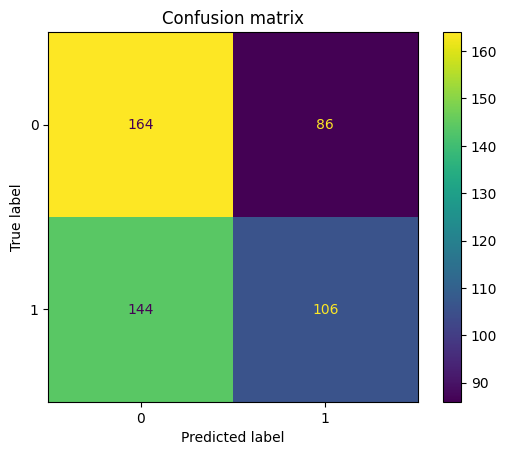

In [21]:
accuracy_matrix = plot_conf_matrix(cnn_metrics)

In [22]:
def plot_confidence_level(metrics):
    plt.figure(figsize=(12, 6))

    plt.hist(metrics["test_confidence"], bins=20, edgecolor = 'black')
    plt.xlabel("Confidence level -> [0, 1]")
    plt.ylabel("Density")
    plt.xticks(np.arange(0, 1.05, 0.05))
    plt.title("Confidence level of predicted value")
    plt.show()

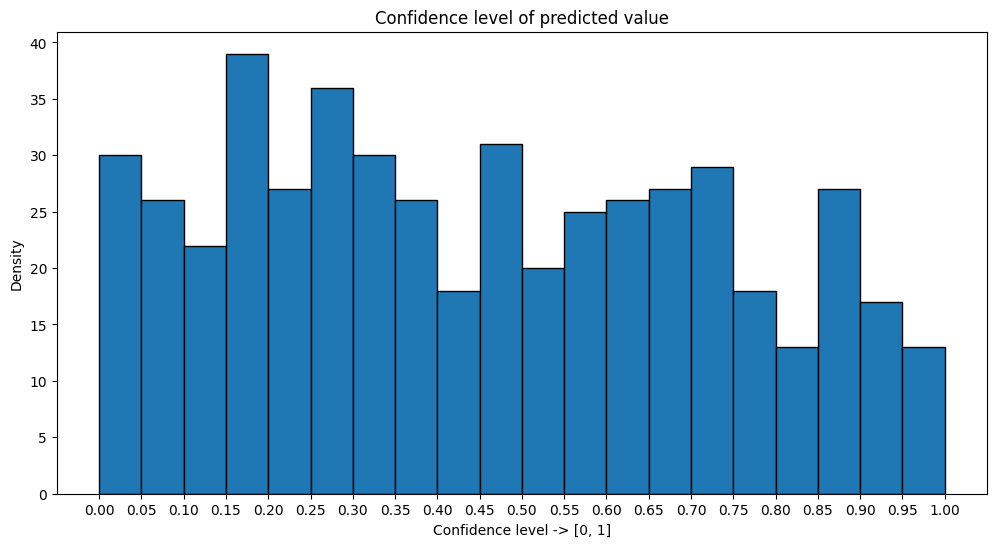

In [23]:
plot_confidence_level(cnn_metrics)

Example of True Negative image (Not classified as harmful and actually NOT harmful) - Without text


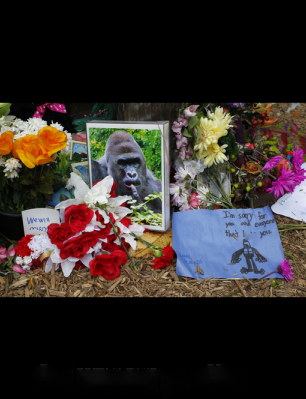

Example of True Positive image (Classified as harmful and actually IS harmful) - Without text


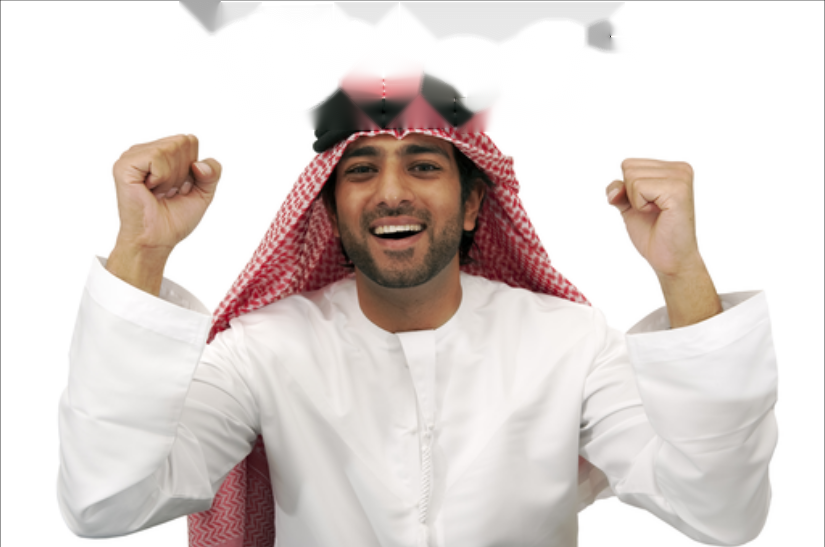

Example of False Negative image (Not classified as harmful and actually IS harmful) - Without text


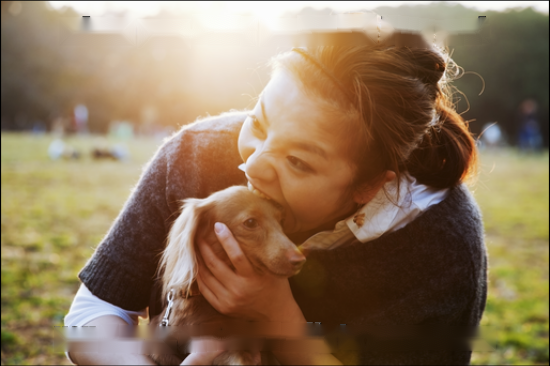

Example of False Positive image (Classified as harmful and actually NOT harmful) - Without text


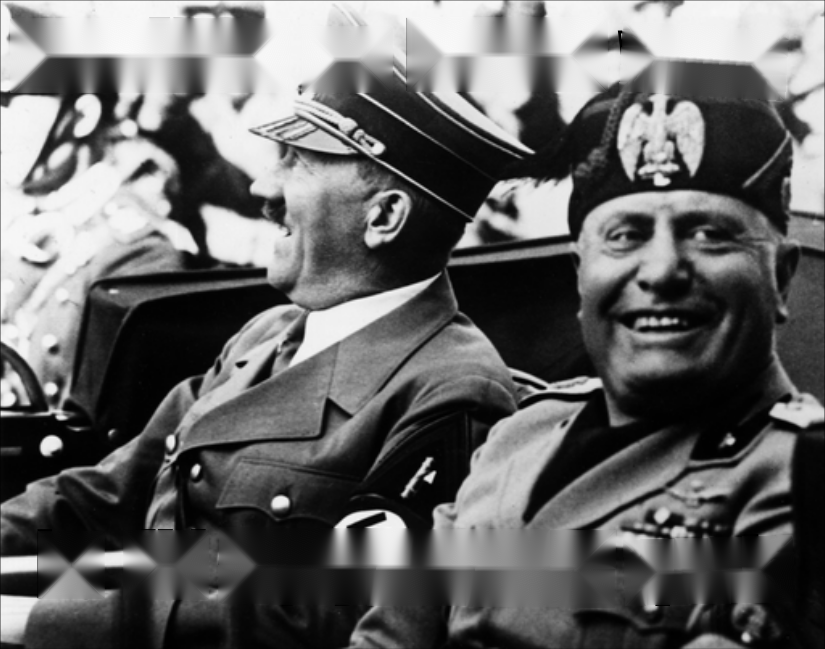

Example of True Negative image (Not classified as harmful and actually NOT harmful) - With text


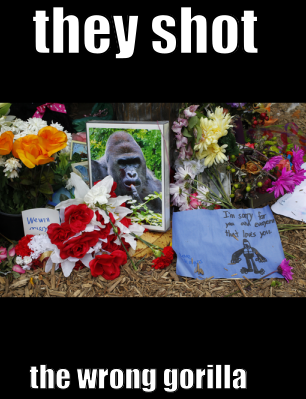

Example of True Positive image (Classified as harmful and actually IS harmful) - With text


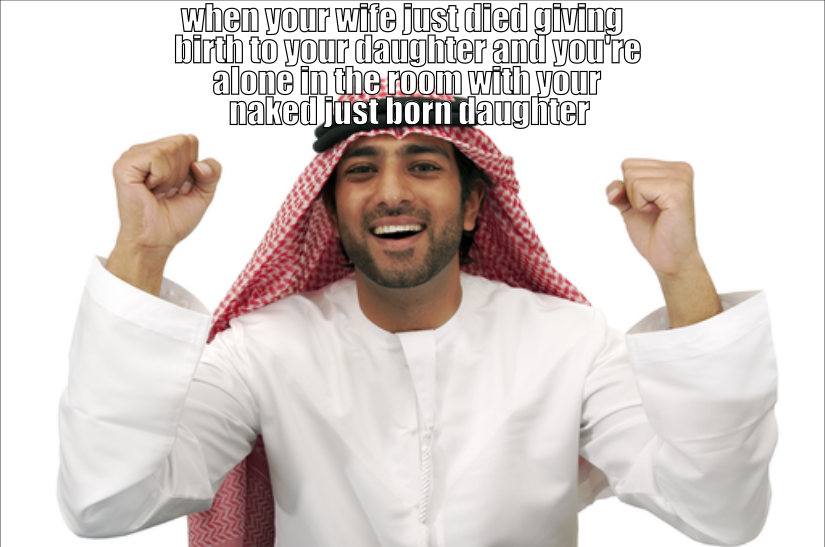

Example of False Negative image (Not classified as harmful and actually IS harmful) - With text


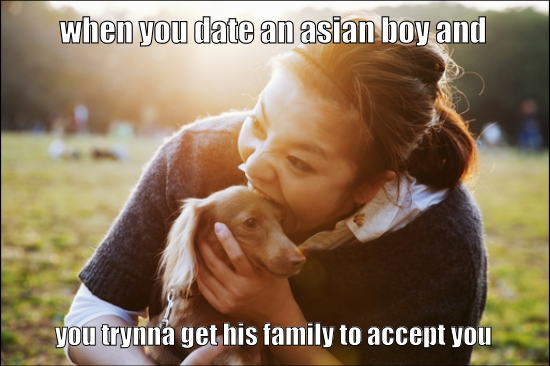

Example of False Positive image (Classified as harmful and actually NOT harmful) - With text


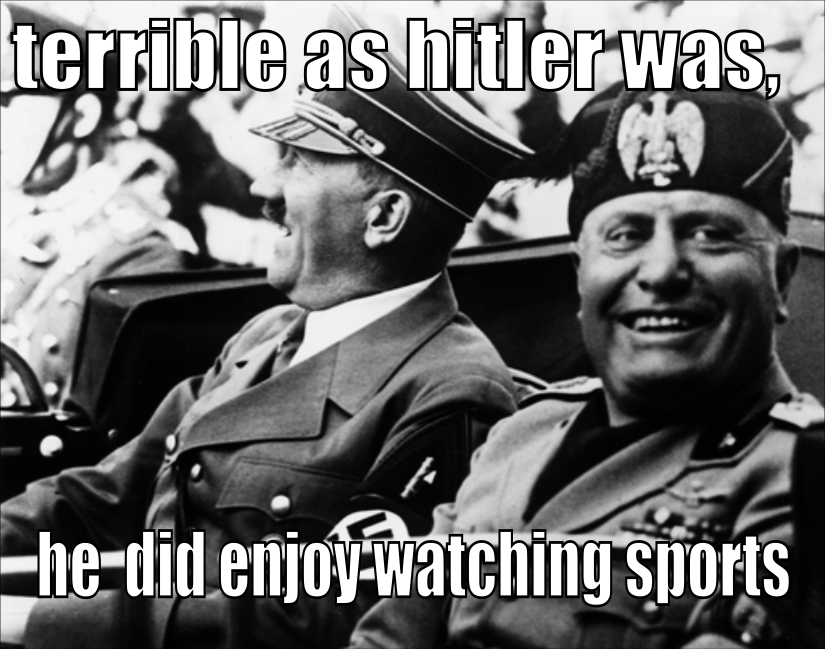

In [39]:
num_classes = accuracy_matrix.shape[0]

# Create a dictionary to hold indices per cell
indices_per_cell = {}

for i in range(num_classes):
    for j in range(num_classes):
        # Find indices where true label == i and predicted label == j
        indices = np.where((cnn_metrics["test_true_labels"] == i) & (cnn_metrics["test_predicted_labels"] == j))[0]
        indices_per_cell[(i, j)] = indices

random_index_tn = np.random.choice(indices_per_cell[(0, 0)])
random_index_tp = np.random.choice(indices_per_cell[(1, 1)])
random_index_fn = np.random.choice(indices_per_cell[(1, 0)])
random_index_fp = np.random.choice(indices_per_cell[(0, 1)])

print(100*"=")
print("Example of True Negative image (Not classified as harmful and actually NOT harmful) - Without text")
image_path = hugging_face_test_df.iloc[random_index_tn].image_path_no_text
img = Image.open(image_path)
display(img)
print(100*"=")
print("Example of True Positive image (Classified as harmful and actually IS harmful) - Without text")
image_path = hugging_face_test_df.iloc[random_index_tp].image_path_no_text
img = Image.open(image_path)
display(img)
print(100*"=")
print("Example of False Negative image (Not classified as harmful and actually IS harmful) - Without text")
image_path = hugging_face_test_df.iloc[random_index_fn].image_path_no_text
img = Image.open(image_path)
display(img)
print(100*"=")
print("Example of False Positive image (Classified as harmful and actually NOT harmful) - Without text")
image_path = hugging_face_test_df.iloc[random_index_fp].image_path_no_text
img = Image.open(image_path)
display(img)
print(100*"=")
print(100*"=")
print(100*"=")
print(100*"=")
print("Example of True Negative image (Not classified as harmful and actually NOT harmful) - With text")
image_path = hugging_face_test_df.iloc[random_index_tn].image_path
img = Image.open(image_path)
display(img)
print(100*"=")
print("Example of True Positive image (Classified as harmful and actually IS harmful) - With text")
image_path = hugging_face_test_df.iloc[random_index_tp].image_path
img = Image.open(image_path)
display(img)
print(100*"=")
print("Example of False Negative image (Not classified as harmful and actually IS harmful) - With text")
image_path = hugging_face_test_df.iloc[random_index_fn].image_path
img = Image.open(image_path)
display(img)
print(100*"=")
print("Example of False Positive image (Classified as harmful and actually NOT harmful) - With text")
image_path = hugging_face_test_df.iloc[random_index_fp].image_path
img = Image.open(image_path)
display(img)
print(100*"=")

## 3. LSTM Model

### 3.1 LSTM Model Description

In [ ]:
VOCAB_SIZE = 7531 #preprocessor.vocab_size


# Check the actual vocabulary size from our preprocessor
print(f"Current preprocessor vocabulary size: {VOCAB_SIZE}")

Current preprocessor vocabulary size: 7531


In [ ]:
class HarmfulMemeClassifier(nn.Module):
    """
    Bidirectional LSTM model for harmful meme text classification

    Architecture:
    - Embedding layer (with optional pre-trained weights)
    - Bidirectional LSTM
    - Dropout for regularization
    - Dense layers for classification
    """

    def __init__(self, vocab_size, embedding_dim=64, hidden_dim=32,
                 num_layers=1, dropout=0.5, num_classes=2):
        super(HarmfulMemeClassifier, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

        # Dense layers for classification
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)  # *2 for bidirectional
        self.fc2 = nn.Linear(hidden_dim, num_classes)

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        """Initialize model weights following best practices"""
        for name, param in self.named_parameters():
            if 'weight' in name:
                if 'lstm' in name:
                    # LSTM weights initialization
                    nn.init.orthogonal_(param.data)
                else:
                    # Dense layer weights
                    nn.init.xavier_uniform_(param.data)
            elif 'bias' in name:
                nn.init.constant_(param.data, 0)

    # def forward(self, x):
    #     # Embedding
    #     embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]

    #     # LSTM
    #     lstm_out, (hidden, cell) = self.lstm(embedded)  # [batch_size, seq_len, hidden_dim*2]

    #     # Use the last output for classification (taking both directions)
    #     last_output = lstm_out[:, -1, :]  # [batch_size, hidden_dim*2]

    #     # Apply dropout
    #     dropped = self.dropout(last_output)

    #     # Dense layers
    #     fc1_out = torch.relu(self.fc1(dropped))  # [batch_size, hidden_dim]
    #     fc1_out = self.dropout(fc1_out)

    #     logits = self.fc2(fc1_out)  # [batch_size, num_classes]

    #     return logits

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)

        # NEW: Use global average pooling instead of last output
        # Create mask to ignore padding tokens
        mask = (x != 0).float().unsqueeze(-1)  # [batch_size, seq_len, 1]

        # Apply mask to LSTM outputs
        masked_output = lstm_out * mask  # [batch_size, seq_len, hidden_dim*2]

        # Calculate average, ignoring padded positions
        sequence_lengths = mask.sum(dim=1)  # [batch_size, 1]
        pooled_output = masked_output.sum(dim=1) / sequence_lengths  # [batch_size, hidden_dim*2]

        # Continue with classification layers
        dropped = self.dropout(pooled_output)
        fc1_out = torch.relu(self.fc1(dropped))
        fc1_out = self.dropout(fc1_out)
        logits = self.fc2(fc1_out)
        return logits

model = HarmfulMemeClassifier(
    vocab_size=VOCAB_SIZE,
    embedding_dim=64,        # Reduced from 128
    hidden_dim=32,           # Reduced from 64
    num_layers=3,            # Reduced from 2
    dropout=0.7,             # Increased from 0.3
    num_classes=2
).to(device)

model.load_state_dict(torch.load("/content/drive/My Drive/IDC_MSc/Year2/NeuralNetworkLearning/FinalProject/harmful_meme_lstm_model.pth", weights_only=False, map_location=device)['model_state_dict'])

# Model summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model Architecture:")
print(f"  Total parameters: {count_parameters(model):,}")
print(f"  Device: {device}")
print("\nModel structure:")
print(model)

AttributeError: Can't get attribute 'ImprovedTextPreprocessor' on <module '__main__'>

In [ ]:
#lstm_model_details = torch.load("/content/drive/My Drive/IDC_MSc/Year2/NeuralNetworkLearning/FinalProject/harmful_meme_lstm_model.pth", weights_only=False, map_location=device)
#lstm_model = lstm_model_details['model_state_dict']
#lstm_processor_test = lstm_model_details['preprocessor']